<a href="https://colab.research.google.com/github/rapidestlime/Eccomerce-SG-Webscraping/blob/main/shopee_scraping_exploration_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import Libraries

Install chromedriver properly on colab properly

In [ ]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap
# https://stackoverflow.com/questions/75155063/selenium-use-chrome-on-colab-got-unexpectedly-exited

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver and snap
apt-get update
apt-get install chromium chromium-driver
sudo apt install snapd

Executing: /tmp/apt-key-gpghome.vfHsmne8tn/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.dOo9Xqy4EB/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.ovlqG0Opfx/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 https://cloud.r-project.org/bin/l

In [ ]:
!pip install selenium-wire

# Load selenium components
from seleniumwire import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import TimeoutException

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 KB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 KB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 7.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling url

In [1]:
# load other crucial libraries
from bs4 import BeautifulSoup
import requests as req
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast
import traceback
import pprint
import gzip
import json


#2.Chrome Driver Set up



In [ ]:
# set up chrome driver
def driversetup():
    caps = DesiredCapabilities().CHROME
    #caps["pageLoadStrategy"] = "normal"  #  Waits for full page load
    caps["pageLoadStrategy"] = "eager"  #  Waits for page to be interactive
    #caps["pageLoadStrategy"] = "none"   # Do not wait for full page load
    options = webdriver.ChromeOptions()
    #run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    #overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
    #open Browser with set window size
    options.add_argument("--window-size=1920,1080")
    #disable infobars
    options.add_argument("disable-infobars")
    #disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")
    # add user agent
    options.add_argument('--user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.106 Safari/537.36"')
    driver = webdriver.Chrome(desired_capabilities=caps,executable_path="/usr/bin/chromedriver",options=options)
    
    return driver


# 3.Function for initial search page driver


In [ ]:
def search_initial_driver(search_term: str, search_type: int):
    """
    Description:
      Set up initial driver state of the the search page based on search type and search term
    Arguments:
      search_term: get the product search term [str object]
      search_type: accepts only (1:"relevance", 2:"latest", 3:"top_sales") [int object]
    Returns:
      final_data: full data of search type relating to search term [pandas dataframe object]
    """
    # initialise base url
    url = f"https://shopee.sg/search?keyword={search_term}&page=0"
    
    # appends url based on search type
    if search_type == 1:
        url += '&sortBy=relevancy'
    elif search_type == 2:
        url += '&sortBy=ctime'
    elif search_type == 3:
        url += '&sortBy=sales'
    else:
        raise Exception("Sorry, only numbers between 1-3")
    
    # load search url with chrome driver 
    Driver = driversetup()
    Driver.get(url)
    
    # make sure search result element is loaded before further action
    WebDriverWait(Driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, "shopee-search-item-result")))
    
    # execute smooth scrolling so that all elements are loaded successfully since they are dynamically loaded
    Driver.execute_script("window.scrollTo({top: document.body.scrollHeight, behavior: 'smooth'});")
    
    # gets number of search pages for later processing
    NumPages = int(Driver.find_element(By.CLASS_NAME, 'shopee-mini-page-controller__total').text)
    
    return (Driver,NumPages)

# Set Search Parameters



 ## ❗ [**Re-run from here if any issues pops up below**] ❗




In [ ]:
search_term = 'sneakers'
search_type = 3
search = search_initial_driver(search_term,search_type)

WebDriverException: ignored

# Initialise Search Containers

Stores search pages data while looping through pages


In [ ]:
# stores search pages data that we Selenium can grab
search_array = {'name': [],
                'min_price': [],
                'max_price' : [],
                'rating': [],
                'image_link' : [],
                'product_link' : [],
                'page_num' : []
                }

Ensure easier referencing & updating of params should Shopee change html structure in future

In [ ]:
search_params = {'results': {'tag' :'script', 'id': {'type':'application/ld+json'}},
                 'name_id_key': "['name']",
                 'price_data_key': "['offers']",
                 'min_price_key': "['lowPrice']",
                 'min_price_key': "['highPrice']",
                 'rating_key': "['ratingValue']",
                 'image_link_key': "['img']",
                 'product_link_key': "['link']"
              }


# 4.Functions For Scraping Summary Page Info

## Create Soup Object Function

In [ ]:
def search_soup_result(Driver, result_tag, result_id):
    """
    Description:
      Grab all elements with matching tags and ids from html page source
    Arguments:
      Driver: Driver state of current search page [webdriver object]
      result_tag: html tag to search in Driver.page_source [str object]
      result_id: id of html tag to search in Driver.page_source [str object]
    Returns:
      list_elements: list of all data under specified tags found in html page [list object]
    """
    soup = BeautifulSoup(Driver.page_source, 'html.parser')
    list_elements = soup.find_all(result_tag,result_id)
    return list_elements

## Search data array Function


In [ ]:
def fill_search_array(search_array, list_elements, page_num):
    """
    Description:
      To fill up search_array container with data in list_elements
    Arguments:
      search_array: get search data placeholder variable [dictionary object]
      list_elements: get params required to locate correct data in parsed soup [dictionary object]
      page_number: current page number to scrape from [integer object]
    """
    
    list_elements = list_elements[6:-5] # removes first 6 and last 5 irrevelant results (other data and ads)
    
    # fill data in search_array variable
    for e in list_elements:
        # converts text to dictionary
        e = ast.literal_eval(e.text)
        
        # add product name
        search_array['name'].append(e['name'])
        
        # add product pricing
        if 'price' in e['offers'].keys(): 
            search_array['min_price'].append(float(e['offers']['price']))
            search_array['max_price'].append(0.0)
        else:
            search_array['max_price'].append(float(e['offers']['highPrice']))
            search_array['min_price'].append(float(e['offers']['lowPrice']))
        
        # add product rating
        search_array['rating'].append(e['aggregateRating']['ratingValue'] if 'aggregateRating' in e.keys() else 0.0)
      
        # add product image link
        search_array['image_link'].append(e['image'])
        
        # asdd product page link
        search_array['product_link'].append(e['url'])
    
        # add page number
        search_array['page_num'].append(page_num)
        

## Function to Loop Through ALL Pages of Summary Output Page

In [ ]:
def scrape_search_pages(search_array, search_params, Driver, NumPages: int):
    """
    Description:
       Loop through and produce data from all search pages based on initial search page driver(1st page)
    Arguments:
        search_array: get search data placeholder variable [dictionary object]
        search_params: get params required to locate correct data in parsed soup [dictionary object]
        Driver: get current chrome driver state [webdriver.Chrome(options=options) object]
        NumPages: get the required number of times Selenium to click for next page [integer object]
    Returns:
        search_page: Pandas Dataframe object of all search pages data
    """
    # assign Driver object
    Driver =  Driver

    # looping to get results from all pages
    for num in range(1,NumPages+1): # ensures clicking NumPages-1 times
        
        # smooth scrolling downwards so that all elements are loaded properly
        Driver.execute_script("window.scrollTo({top: document.body.scrollHeight, behavior: 'smooth'});")
        time.sleep(2)
        WebDriverWait(Driver, 30).until(EC.visibility_of_all_elements_located((By.CLASS_NAME, "ZnrnMl")))
        
        # get html soup and get all search results on that page
        list_elements = search_soup_result(Driver,
                                                 search_params['results']['tag'],
                                                 search_params['results']['id']
                                                 )
        
        # fill data in search_array variable
        fill_search_array(search_array,list_elements,num)
        
        # initiates scroll back top and clicking next button
        if num < NumPages: # ensures final page next button wont be clicked
            Driver.execute_script("window.scrollTo(0,0);") # scrolls back to top for smooth scrolling the next page
            next_button = Driver.find_element(By.XPATH,'//button[@class="shopee-button-outline shopee-mini-page-controller__next-btn"]')
            next_button.click() # tells selenium to click the next button
            WebDriverWait(Driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, "shopee-search-item-result"))) # wait for search result element to be detected
            time.sleep(2) # gives driver enough time to load the next page, avoid scraping detection
    
    # create dataframe
    search_pages = pd.DataFrame.from_dict(search_array)
    
    Driver.close() # close off webdriver object
    return search_pages # ---> toggle no. of rows for quick testing with indexing if needed

# Run Multi Summary Pages Loop Function

 Produce dataframe from search results of "sneakers" which we derive from initial driver state "search"





In [ ]:
search_dataframe = scrape_search_pages(search_array, search_params, search[0], 6)
search_dataframe

,name,min_price,max_price,rating,image_link,product_link
0,Hot selling！Ready Stock 24H Send women air for...,19.07,0.0,4.77,https://cf.shopee.sg/file/a4b15c3efed1b621690f...,https://shopee.sg/Hot-selling！Ready-Stock-24H-...
1,Af1 Sneakers With gold Streaks In black Air Fo...,21.59,0.0,4.65,https://cf.shopee.sg/file/sg-11134201-22110-9n...,https://shopee.sg/Af1-Sneakers-With-gold-Strea...
2,Jordan JD1 high Neck Sneakers Full color basic...,21.49,0.0,4.58,https://cf.shopee.sg/file/sg-11134201-22120-97...,https://shopee.sg/Jordan-JD1-high-Neck-Sneaker...
3,Skechers Women Active Breathe-Easy Shoes - 100...,99.00,0.0,4.95,https://cf.shopee.sg/file/sg-11134201-23010-p0...,https://shopee.sg/Skechers-Women-Active-Breath...
4,IELGY Wild little white lace buckle Korean ca...,10.71,0.0,4.64,https://cf.shopee.sg/file/ef8b6d6a69584326753c...,https://shopee.sg/IELGY-Wild-little-white-lace...
...,...,...,...,...,...,...
295,[ORIGINAL] Women's Sperry Crest Vibe Linen Tex...,89.90,0.0,4.92,https://cf.shopee.sg/file/f3305ea909acd8ceb37a...,https://shopee.sg/-ORIGINAL-Women's-Sperry-Cre...
296,SUPERGA X EARPEARP Superga 2750 Sneakers Print...,77.76,0.0,5.00,https://cf.shopee.sg/file/abb762dd676d58ae96bf...,https://shopee.sg/SUPERGA-X-EARPEARP-Superga-2...
297,in stock NK SB Dunk Low Fog Black Gum Womens a...,57.93,0.0,5.00,https://cf.shopee.sg/file/4c4f8839d525f671bca7...,https://shopee.sg/in-stock-NK-SB-Dunk-Low-Fog-...
298,Air Jordan 1 Low Travis Scott Fragment Low Tub...,59.29,0.0,5.00,https://cf.shopee.sg/file/9c2498e75f887cddb15a...,https://shopee.sg/Air-Jordan-1-Low-Travis-Scot...


We will get search_dataframe, which consists of the following data:

- name: name of product listing
- min_price: minimum price of product listing
- max_price: maximum price of product listing
- image_link: link to listing image
- product_link: link to product listing page
- page_num: which page product is appearing on

# 5.Functions To Scrape Individual Product Pages

## Function to get PRODUCT page details from backend api request


In [ ]:
def get_product_data(driver):
    """
    Description:
      Retreives data from shopee product data backend api
    Arguments:
      driver: gets current state of product page [webdriver object]
    Returns:
      product_data: full product details by backend api [dictionary object]
      shop_data: full shop details by backend api [dictionary object]
      shipping_data: full shipping details by backend api [dictionary object]
    """
    product_data = None
    shop_data = None

    product_sub_url = 'https://shopee.sg/api/v4/item/get?itemid=' # to match correct request for product
    shop_sub_url = 'https://shopee.sg/api/v4/product/get_shop_info?shopid=' # to match correct request for shop info

    for request in driver.requests:
        if request and product_sub_url in request.url:
            decompress = gzip.decompress(request.response.body).decode()
            product_data = json.loads(decompress)      
        elif request and shop_sub_url in request.url:
            shop_data = json.loads(request.response.body)
        else:
            pass
    
    return product_data,shop_data

## Product data array Function

In [ ]:
def fill_product_array(product_data,shop_data,product_array,product_params):
    """
    Description:
      fill up product_array that stores all product data
    Arguments:
      product_data: gets product data [dictionary object]
      shop_data: gets information about seller shop [dictionary object]
      product_array: get product data placeholder [dictionary object]
      product_params: get required dictionary keys for referencing in product data [dictionary object]
    """

    # fills up arrays in product_array

    for k,v in product_params.items():
        try:
            if 'star_ratings' in k:
                data = product_data.get(v[0]).get(v[1]).get(v[2])[v[3]]
                product_array.get(k).append(0 if data == None else data)
            elif 'category' in k:
                data = product_data.get(v[0]).get(v[1])[v[2]].get(v[3])
                product_array.get(k).append(0 if data == None else data)
            elif k in ('shop_name','shop_followers','response_rate'):
                data = shop_data.get(v[0]).get(v[1])
                product_array.get(k).append(0 if data == None else data)
            else:
                data = product_data.get(v[0]).get(v[1])
                product_array.get(k).append(0 if data == None else data)
        except:
            print(v)
            raise Exception(print(product_data))

  

```
product_params = {'SG_sold' : "['data']['sold']",
                 'global_sold': "['data']['global_sold']",
                 '30day_sold': "['data']['historical_sold']",
                 'stock_level': "['data']['stock']",
                 'total_ratings' : "['data']['cmt_count']",
                 '1_star_ratings' : "['data']['item_rating']['rating_count'][1]",
                 '2_star_ratings' : "['data']['item_rating']['rating_count'][2]",
                 '3_star_ratings' : "['data']['item_rating']['rating_count'][3]",
                 '4_star_ratings' : "['data']['item_rating']['rating_count'][4]",
                 '5_star_ratings' : "['data']['item_rating']['rating_count'][5]",
                 'origin' : "['data']['shop_location']",
                 'discount': "['data']['show_discount']",
                 'main_category' : "['data']['fe_categories'][0]['display_name']",
                 'sub_category' : "['data']['fe_categories'][1]['display_name']",
                 'group_category' : "['data']['fe_categories'][2]['display_name']",
                 'liked' : "['data']['liked']",
                 'is_shopee_verified': "['data']['shopee_verified']",
                 'is_preferred_plus': "['data']['is_preferred_plus_seller']",
                 'is_official_shop': "['data']['is_official_shop']",
                 'item_id': "['data']['itemid']",
                 'shop_id': "['data']['shopid']",
                 'shop_name': "['data']['name']",
                 'shop_followers': "['data']['follower_count']",
                 'response_rate': "['data']['response_rate']"
                }
```



## Function to Iterate Through All produce product detail Pages

In [ ]:
def scrape_product_pages(search_dataframe,product_array, product_params):
    """
    Description:
      Loop through all product links and get all product data
    Arguments:
      search_dataframe: dataframe from scrape_search_pages func [pandas dataframe object]
    Returns:
      product_dataframe: dataframe containing info from product pages [pandas dataframe object]
    """
    url_list = search_dataframe['product_link']
    Driver = driversetup()
    for url in url_list:
        Driver.get(url)
        time.sleep(3)
        Driver.execute_script("window.scrollTo({top: document.body.scrollHeight, behavior: 'smooth'});")
        time.sleep(3)
        product_data,shop_data = get_product_data(Driver)
        fill_product_array(product_data,shop_data,product_array,product_params)
        Driver.execute_script("window.scrollTo(0,0);")
    
    Driver.close()

    product_dataframe = pd.DataFrame.from_dict(product_array)

    return product_dataframe


# Initialize Product Containers

In [ ]:
#initialise dictionary of data arrays relevant to be scrapped from search

In [ ]:
product_array = {'SG_sold' : [],
                 'global_sold': [],
                 '30day_sold': [],
                 'stock_level': [],
                 'total_ratings' : [],
                 '1_star_ratings' : [],
                 '2_star_ratings' : [],
                 '3_star_ratings' : [],
                 '4_star_ratings' : [],
                 '5_star_ratings' : [],
                 'origin' : [],
                 'discount': [],
                 'main_category' : [],
                 'sub_category' : [],
                 'group_category' : [],
                 'liked' : [],
                 'is_shopee_verified': [],
                 'is_preferred_plus': [],
                 'is_official_shop': [],
                 'item_id': [],
                 'shop_id': [],
                 'shop_name': [],
                 'shop_followers': [],
                 'response_rate': []
                }

In [ ]:
# initialise parameters for referencing to get correct data from parsed api request response

In [ ]:
product_params = {'SG_sold' : ['data','sold'],
                 'global_sold': ['data','global_sold'],
                 '30day_sold': ['data','historical_sold'],
                 'stock_level': ['data','stock'],
                 'total_ratings' : ['data','cmt_count'],
                 '1_star_ratings' : ['data','item_rating','rating_count',1],
                 '2_star_ratings' : ['data','item_rating','rating_count',2],
                 '3_star_ratings' : ['data','item_rating','rating_count',3],
                 '4_star_ratings' : ['data','item_rating','rating_count',4],
                 '5_star_ratings' : ['data','item_rating','rating_count',5],
                 'origin' : ['data','shop_location'],
                 'discount': ['data','show_discount'],
                 'main_category' : ['data','fe_categories',0,'display_name'],
                 'sub_category' : ['data','fe_categories',1,'display_name'],
                 'group_category' : ['data','fe_categories',2,'display_name'],
                 'liked' : ['data','liked'],
                 'is_shopee_verified': ['data','shopee_verified'],
                 'is_preferred_plus': ['data','is_preferred_plus_seller'],
                 'is_official_shop': ['data','is_official_shop'],
                 'item_id': ['data','itemid'],
                 'shop_id': ['data','shopid'],
                 'shop_name': ['data','name'], # shop_data
                 'shop_followers': ['data','follower_count'], # shop_data
                 'response_rate': ['data','response_rate'] # shop_data
                }

# Run Function To Create Indiv Product Information



In [ ]:
product_dataframe = scrape_product_pages(search_dataframe[0:25],product_array,product_params)
product_dataframe

,SG_sold,global_sold,30day_sold,stock_level,total_ratings,1_star_ratings,2_star_ratings,3_star_ratings,4_star_ratings,5_star_ratings,...,group_category,liked,is_shopee_verified,is_preferred_plus,is_official_shop,item_id,shop_id,shop_name,shop_followers,response_rate
0,112,266,266,368079,92,1,1,3,8,79,...,Women's Sneakers,False,False,False,False,21627555991,696750773,Fashion shoes *store,527,78
1,97,294,109,5979,52,0,3,2,5,42,...,Low Top Sneakers,False,False,False,False,21462405956,779400615,menshop19o3.sg,564,92
2,91,550,234,47697,90,3,2,4,12,69,...,High Top Sneakers,False,False,False,False,19805329831,779400615,menshop19o3.sg,564,92
3,74,0,158,155,76,0,0,0,4,72,...,Women's Sneakers,False,False,False,True,16585096971,84710867,Skechers Singapore,147232,100
4,66,435,435,5660,186,3,1,14,24,144,...,Women's Sneakers,False,False,False,True,487473348,11569559,IELGY Women's Shoes Official Store,24616,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,42,211,177,1508,88,3,3,4,10,68,...,Running Shoes,False,False,False,False,20327002351,230411063,LX MALL,1981,76
296,35,0,123,303,52,0,0,1,3,48,...,Women's Sneakers,False,False,False,True,21945244914,84710867,Skechers Singapore,147241,100
297,39,217,83,42460,23,1,1,2,3,16,...,Women's Sneakers,False,False,False,False,20905329454,779400615,menshop19o3.sg,564,92
298,37,388,193,38909,77,4,1,5,6,61,...,Women's Sneakers,False,False,False,False,21805323271,779400505,skylamadawo.sg,407,100


In [ ]:
product_dataframe.to_csv('shopee_top_sales_product_dataframe_24rows') # took 7.5mins for 25 products

We will get search_dataframe, which consists of the following data:

- 'SG_sold' : total stock sold in SG
- 'global_sold': total stock sold gloablly
- '30day_sold': total stock sold past 30 days
- 'stock_level': total stock levels
- 'total_ratings' : number of ratings
- '1_star_ratings': number of 1 star ratings
- '2_star_ratings': number of 2 star ratings
- '3_star_ratings': number of 3 star ratings
- '4_star_ratings': number of 4 star ratings
- '5_star_ratings': number of 5 star ratings
- 'origin' : shipping origin
- 'discount': current discount % for product
- 'main_category' : main category (1st)
- 'sub_category' : sub category (2nd)
- 'group_category' : group catgeory (3rd)
- 'liked' : number of likes on product listing
- 'is_shopee_verified': boolean on whether seller is verified
- 'is_preferred_plus': boolean on whether seller is under prefered plus
- 'is_official_shop': boolean on whether shop is official
- 'item_id': id of listing
- 'shop_id': id of seller
- 'shop_name': shop name
- 'shop_followers': number of people following shop
- 'response rate': rate of seller responding to enquiries


# 6.Combine Summary and Product Dataframes to achieve final dataframe

In [16]:
#combines 2 dataframe
def combine_dataframe(search_dataframe, product_dataframe):
    return pd.concat([search_dataframe,product_dataframe],axis=1)

In [20]:
search_dataframe =pd.read_csv('/content/drive/MyDrive/Data Files/E commerce web scraping/shopee_top_sales_search_data.csv',index_col=0)
product_dataframe =pd.read_csv('/content/drive/MyDrive/Data Files/E commerce web scraping/shopee_top_sales_product_dataframe_24rows',index_col=0) 
final_dataframe = combine_dataframe(search_dataframe,product_dataframe)
final_dataframe

,name,min_price,max_price,rating,image_link,product_link,SG_sold,global_sold,30day_sold,stock_level,...,group_category,liked,is_shopee_verified,is_preferred_plus,is_official_shop,item_id,shop_id,shop_name,shop_followers,response_rate
0,Hot selling！Ready Stock 24H Send women air for...,19.07,0.0,4.77,https://cf.shopee.sg/file/a4b15c3efed1b621690f...,https://shopee.sg/Hot-selling！Ready-Stock-24H-...,112,266,266,368079,...,Women's Sneakers,False,False,False,False,21627555991,696750773,Fashion shoes *store,527,78
1,Af1 Sneakers With gold Streaks In black Air Fo...,21.59,0.0,4.65,https://cf.shopee.sg/file/sg-11134201-22110-9n...,https://shopee.sg/Af1-Sneakers-With-gold-Strea...,97,294,109,5979,...,Low Top Sneakers,False,False,False,False,21462405956,779400615,menshop19o3.sg,564,92
2,Jordan JD1 high Neck Sneakers Full color basic...,21.49,0.0,4.58,https://cf.shopee.sg/file/sg-11134201-22120-97...,https://shopee.sg/Jordan-JD1-high-Neck-Sneaker...,91,550,234,47697,...,High Top Sneakers,False,False,False,False,19805329831,779400615,menshop19o3.sg,564,92
3,Skechers Women Active Breathe-Easy Shoes - 100...,99.00,0.0,4.95,https://cf.shopee.sg/file/sg-11134201-23010-p0...,https://shopee.sg/Skechers-Women-Active-Breath...,74,0,158,155,...,Women's Sneakers,False,False,False,True,16585096971,84710867,Skechers Singapore,147232,100
4,IELGY Wild little white lace buckle Korean ca...,10.71,0.0,4.64,https://cf.shopee.sg/file/ef8b6d6a69584326753c...,https://shopee.sg/IELGY-Wild-little-white-lace...,66,435,435,5660,...,Women's Sneakers,False,False,False,True,487473348,11569559,IELGY Women's Shoes Official Store,24616,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,[ORIGINAL] Women's Sperry Crest Vibe Linen Tex...,89.90,0.0,4.92,https://cf.shopee.sg/file/f3305ea909acd8ceb37a...,https://shopee.sg/-ORIGINAL-Women's-Sperry-Cre...,42,211,177,1508,...,Running Shoes,False,False,False,False,20327002351,230411063,LX MALL,1981,76
296,SUPERGA X EARPEARP Superga 2750 Sneakers Print...,77.76,0.0,5.00,https://cf.shopee.sg/file/abb762dd676d58ae96bf...,https://shopee.sg/SUPERGA-X-EARPEARP-Superga-2...,35,0,123,303,...,Women's Sneakers,False,False,False,True,21945244914,84710867,Skechers Singapore,147241,100
297,in stock NK SB Dunk Low Fog Black Gum Womens a...,57.93,0.0,5.00,https://cf.shopee.sg/file/4c4f8839d525f671bca7...,https://shopee.sg/in-stock-NK-SB-Dunk-Low-Fog-...,39,217,83,42460,...,Women's Sneakers,False,False,False,False,20905329454,779400615,menshop19o3.sg,564,92
298,Air Jordan 1 Low Travis Scott Fragment Low Tub...,59.29,0.0,5.00,https://cf.shopee.sg/file/9c2498e75f887cddb15a...,https://shopee.sg/Air-Jordan-1-Low-Travis-Scot...,37,388,193,38909,...,Women's Sneakers,False,False,False,False,21805323271,779400505,skylamadawo.sg,407,100


# 7.Data Preprocessing

## Create Product Turnover Rate

Tells you how extent of over and understocking of specified product

Product Turnover Rate = 30day_sold / stock_level

In [36]:
final_dataframe['turnover_rate'] = final_dataframe['30day_sold']/final_dataframe['stock_level']

# 8.Data Insights Extracted

## Top x Current Selling Products




Tells you top x sellings products on Shopee by monthly sales

In [22]:
final_dataframe.sort_values(by=['30day_sold'], ascending=False).head()[['name','30day_sold']]

,name,30day_sold
262,[Superga] 2750 GOTU Classic sneakers Total Beige,1424
291,Kitchen Special Shoes Women Anti-Slip Waterpro...,1424
53,adidas ORIGINALS Superstar Shoes Sneaker GY2073,1424
16,MUJI Ladies Walk Support Water Repellent Sneakers,1424
294,Josepht Smith Leather Sneakers Navy Smith Sand...,1119


## Top x Highly Liked Products

Tells you top x products with very high interest on Shopee

In [23]:
final_dataframe.sort_values(by=['liked'], ascending=False).head()[['name','liked']]

,name,liked
0,Hot selling！Ready Stock 24H Send women air for...,False
206,FILA Court Deluxe Velcro Unisex Sneakers,False
204,PL2 READY STOCK NIK@ AF1 AIRFORCE 1 HIGH TOP L...,False
203,So STORM Women's SNEAKERS Shoes,False
202,Toko - Women's Korean SNEAKERS WHY TEDDY BEAR ...,False


## Top X Selling Sub Categories

Tells you top selling sub categories in which you may find cross sell opportunites

In [24]:
final_dataframe.groupby(by=["sub_category"]).sum().sort_values(by=['30day_sold'],ascending=False)['30day_sold'].head()

sub_category
Sneakers                     52756
Men Sports Attire & Shoes     1558
Shoe Accessories              1135
Baby & Kids Shoes                2
Name: 30day_sold, dtype: int64

## Top X Selling Group Categories

Tells you top selling group categories in which you may find cross sell opportunites

In [25]:
final_dataframe.groupby(by=["group_category"]).sum().sort_values(by=['30day_sold'],ascending=False)['30day_sold']

group_category
Women's Sneakers     28209
Low Top Sneakers     22750
High Top Sneakers     1585
Running Shoes         1512
Shoe Care             1135
Others                 212
Basketball Shoes        46
School Shoes             2
Name: 30day_sold, dtype: int64

## Top X Sellers by Sales




Tells you top ranking sellers on shopee by thier monthly sales or total sales

- based on past 30 day sales

In [26]:
final_dataframe.groupby(by=["shop_name"]).sum().sort_values(by=['30day_sold'],ascending=False)['30day_sold'].head()

shop_name
MUJI Official Store                    9212
12km.sg                                6420
A.W-shop                               4476
SooStore                               4223
 IELGY Women's Shoes Official Store    2713
Name: 30day_sold, dtype: int64

- based on historical total sales

In [28]:
final_dataframe.groupby(by=["shop_name"]).sum().sort_values(by=['global_sold'],ascending=False)['global_sold'].head()

shop_name
Toko Sepatu  Disna          34900
ventela_agen.sg             26465
ayrashoes01.sg              18290
pendekar1945.sg             17860
Diva Store Official Shop    16401
Name: global_sold, dtype: int64

## Price Distribution of Best Selling Product




Tells sellers price dist of best selling product by 30day_sales

In [29]:
top5_30d_sales = final_dataframe.sort_values(by=['30day_sold'], ascending=False).head()
top5_30d_sales['min_price'].describe()

count      5.000000
mean      72.024000
std       61.708573
min       16.070000
25%       16.450000
50%       72.360000
75%       90.000000
max      165.240000
Name: min_price, dtype: float64

## Discount % Distribution of Best Selling Product

- tells seller discount distribution for recent best selling products where it is defined to be more than x past 30 days sales e.g. >20 is defined to be very good sales

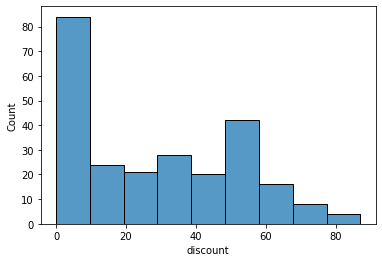

In [30]:
sns.histplot(final_dataframe[final_dataframe['30day_sold']>20]['discount'])

## Response Rate Distribution for Best Selling Products

## Top X Shop Origin

tells seller what is the top best product's shop name and location of shop based on past 30 days sales

In [33]:
final_dataframe.sort_values(by=['30day_sold'], ascending=False).head()[['shop_name','origin']]

,shop_name,origin
262,MUJI Official Store,Singapore
291,MUJI Official Store,Singapore
53,MUJI Official Store,Singapore
16,MUJI Official Store,Singapore
294,A.W-shop,Mainland China


## Countplot of is_official store for tops selling

- see if people have the habit of buying mainly from official or non official shops

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


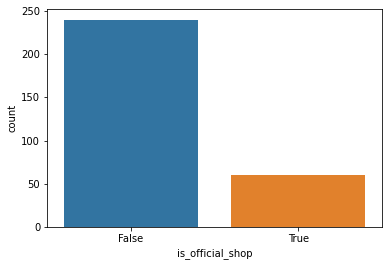

In [34]:
sns.countplot(final_dataframe.sort_values(by=['30day_sold'], ascending=False)['is_official_shop'])

## Product Turnover Rate distribution of top selling prducts

- tells seller product distribution for recent best selling products where it is defined to be more than x past 30 days sales e.g. >20 is defined to be very good sales
- gives seller a benchmark to follow when selling goods

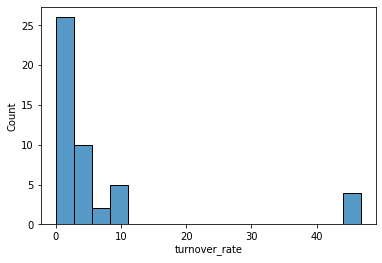

In [40]:
sns.histplot(final_dataframe[final_dataframe['30day_sold']>300]['turnover_rate'])